Starting GridSearchCV for hyperparameter tuning...

Training Metrics
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, AROC: 1.0000
Testing Metrics
Accuracy: 0.9300, Precision: 0.9398, Recall: 0.9300, F1 Score: 0.9270, AROC: 0.9457


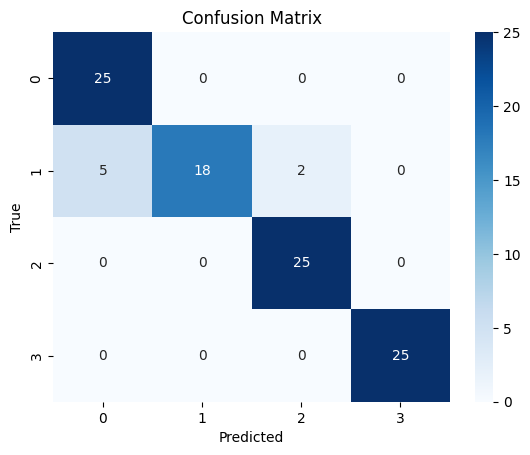

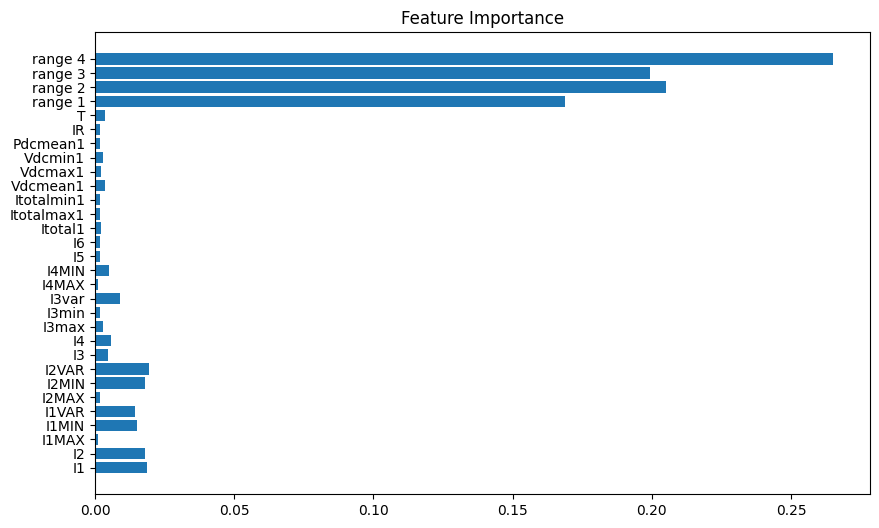

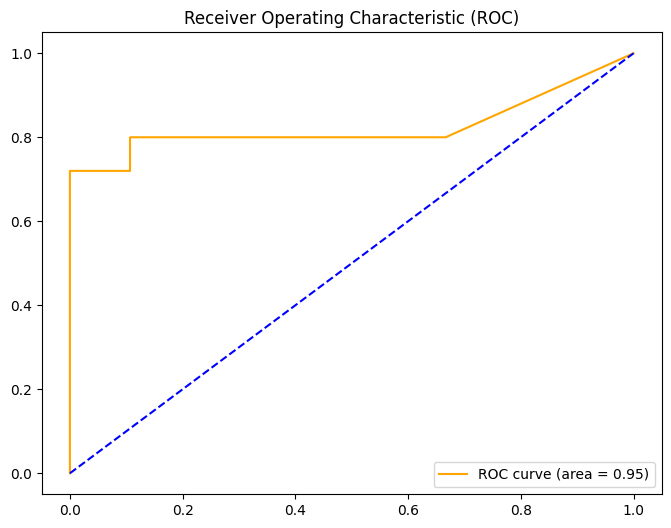

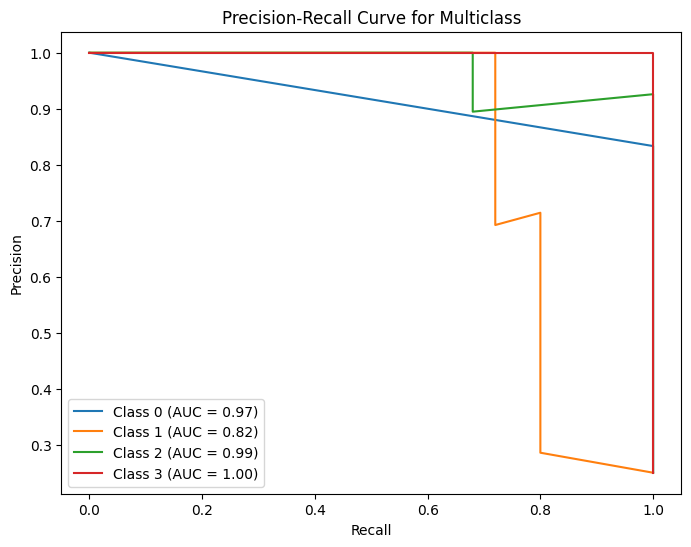

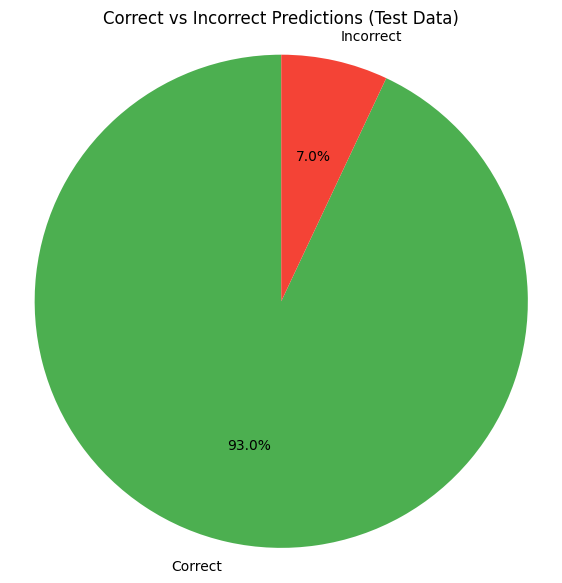

Predictions with Ground Truth for Test Data (Showcasing a few rows):
   Row Number  Ground Truth  Predicted
0           0             2          2
1           1             2          2
2           2             2          2
3           3             2          2
4           4             2          2
GridSearchCV completed and model evaluation finished.


In [3]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load the dataset
train_data = pd.read_csv('/kaggle/input/organized-eee/organized_train_data.csv')
test_data = pd.read_csv('/kaggle/input/organized-eee/organized_test_data.csv')

# Extract features and target
X_train = train_data.drop(columns=['class'])
y_train = train_data['class']
X_test = test_data.drop(columns=['class'])
y_test = test_data['class']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define base models for stacking
base_learners = [
    ('ada', AdaBoostClassifier(n_estimators=50, learning_rate=0.1)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=5)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# Stacking classifier
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=AdaBoostClassifier())

# Hyperparameter tuning with GridSearchCV for stacking model
param_grid = {
    'ada__n_estimators': [50, 100],
    'rf__max_depth': [5, 10],
    'gb__learning_rate': [0.05, 0.1],
    'final_estimator__n_estimators': [50, 100],
}

# Wrapping GridSearchCV with tqdm for progress monitoring
grid_search = GridSearchCV(stacking_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Adding tqdm to show progress of fitting
tqdm.write("Starting GridSearchCV for hyperparameter tuning...\n")
grid_search.fit(X_train_scaled, y_train)

# Get best model from GridSearchCV
best_model = grid_search.best_estimator_

# Model evaluation
train_preds = best_model.predict(X_train_scaled)
test_preds = best_model.predict(X_test_scaled)

train_accuracy = best_model.score(X_train_scaled, y_train)
test_accuracy = best_model.score(X_test_scaled, y_test)
train_precision = precision_score(y_train, train_preds, average='macro')
test_precision = precision_score(y_test, test_preds, average='macro')
train_recall = recall_score(y_train, train_preds, average='macro')
test_recall = recall_score(y_test, test_preds, average='macro')
train_f1 = f1_score(y_train, train_preds, average='macro')
test_f1 = f1_score(y_test, test_preds, average='macro')
train_auc = roc_auc_score(y_train, best_model.predict_proba(X_train_scaled), multi_class='ovr')
test_auc = roc_auc_score(y_test, best_model.predict_proba(X_test_scaled), multi_class='ovr')

# Display metrics
print(f"Training Metrics\nAccuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}, AROC: {train_auc:.4f}")
print(f"Testing Metrics\nAccuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}, AROC: {test_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Feature Importance Plot
# Extract the feature importance from the RandomForest base model (if applicable)
rf_model = best_model.named_estimators_['rf']  # Access the RandomForest model from the stacking classifier
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    features = X_train.columns
    plt.figure(figsize=(10,6))
    plt.barh(features, importances)
    plt.title("Feature Importance")
    plt.show()
else:
    print("No feature importance available for this model.")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test_scaled)[:, 1], pos_label=1)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve for multiclass classification
n_classes = len(np.unique(y_test))  # Get the number of unique classes
plt.figure(figsize=(8, 6))

# Compute Precision-Recall curve for each class
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test == i, best_model.predict_proba(X_test_scaled)[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AUC = {roc_auc_score(y_test == i, best_model.predict_proba(X_test_scaled)[:, i]):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass')
plt.legend(loc='lower left')
plt.show()

# Pie chart showing Correct vs Incorrect Predictions
correct_predictions = np.sum(test_preds == y_test)
incorrect_predictions = np.sum(test_preds != y_test)
labels = ['Correct', 'Incorrect']
sizes = [correct_predictions, incorrect_predictions]

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#F44336'])
plt.title('Correct vs Incorrect Predictions (Test Data)')
plt.axis('equal')
plt.show()

# Show predictions with corresponding row numbers (ground truth vs predicted)
predictions_df = pd.DataFrame({
    'Row Number': test_data.index,
    'Ground Truth': y_test,
    'Predicted': test_preds
})

# Save the predictions to a CSV file
predictions_df.to_csv('/kaggle/working/organized_test_data_prediction.csv', index=False)

print("Predictions with Ground Truth for Test Data (Showcasing a few rows):")
print(predictions_df.head())

# Final message
tqdm.write("GridSearchCV completed and model evaluation finished.")
